# Return Path Interview Challenge
<img src="rp.png">

### Challenge Description
Return Path's customers include large retailers, digital marketers, and publishers. All of these customers share a desire to send emails that are wanted and will be read by their customers. A key step both in optimizing those efforts and in preparing operationally before deploying a campaign is identifying how many of the subscribers they intend to send to are likely to read a specific email campaign. You are given a set of data that shows attributes both of the list to be sent and the historical results of the sender. Your task is to see if you can accurately predict the read rate of a campaign prior to it being sent.

### <font color='red'>**Honest disclaimer:**</font> 

All of the ideas and code represented in this notebook were compiled by me alone. However, there is no way I could have coded everything below relying solely on my memory and independent ingenuity. I borrowed ideas and thoughts from around the Internet and relied on code documentation, previous classes (edX, Coursera, Udacity), StackExchange, and numerous blog posts. I attempt to give credit to a source where I can. In particular, I found ideas that I learned while completing the [Data Science and Engineering with Spark XSeries](https://www.edx.org/xseries/data-science-engineering-apache-spark) particularly useful.

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt


In [2]:
# Read the interview data csv into a pandas dataframe
email_data = pd.read_csv("interview_data.csv")

# Exploratory Data Analysis

In [3]:
# Print out the size of the dataset and a sample of ten rows
print("Row count: ", email_data.shape[0])
print("Column count: ", email_data.shape[1])
email_data.head(10)

Row count:  70000
Column count:  19


,id,read_rate,from_domain_hash,Domain_extension,day,campaign_size,unique_user_cnt,avg_domain_read_rate,avg_domain_inbox_rate,avg_user_avg_read_rate,avg_user_domain_avg_read_rate,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
0,1,0.142857,27b0d9f2946586e2714e3b4312bc8207,br,Sat,14,14,0.090180,0.104208,0.184311,0.205275,0.214286,0.428571,0.000000,0.000000,0.000000,0.142857,0.214286,0.0000
1,2,0.000000,b10a5c38ffad692959a42353fd2896f2,com,Wed,39,39,0.005406,0.008427,0.058590,0.000000,0.128205,0.102564,0.410256,0.153846,0.000000,0.179487,0.025641,0.0000
2,3,0.500000,f8a9fa3e4cbeb4436c4eaf9183df2cbf,com,Fri,18,2,0.302676,0.970434,0.055645,0.433333,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.0000
3,4,0.134615,6dc9420f4bcb2746186f64cf5072d1fa,com,Sun,52,52,0.141473,0.776517,0.169429,0.182516,0.196078,0.215686,0.294118,0.176471,0.000000,0.078431,0.039216,0.0000
4,5,0.000000,a37f0e9827536a9bb709b1b505d57aa9,com,Sun,17,17,0.018936,0.028425,0.052422,0.000000,0.058824,0.294118,0.176471,0.176471,0.000000,0.235294,0.058824,0.0000
5,6,0.081395,636ae4d78ec2b46248fc59ac1ad737df,com,Tues,86,81,0.047170,0.921084,0.070127,0.068677,0.082353,0.094118,0.176471,0.211765,0.000000,0.294118,0.141176,0.0000
6,7,0.000000,50cd1a9a183758039b0841aa738c3f0b,com,Sat,26,13,0.263610,0.549274,0.148604,0.195067,0.083333,0.833333,0.000000,0.000000,0.000000,0.083333,0.000000,0.0000
7,8,0.076923,f74d39fa044aa309eaea14b9f57fe79c,com,Sat,13,13,0.191301,0.687119,0.045145,0.038261,0.000000,0.923077,0.000000,0.000000,0.076923,0.000000,0.000000,0.0000
8,9,0.000000,d30663cb0bed60805ad3ae4ebbad217b,com,Mon,16,16,0.061572,0.232203,0.006040,0.000250,0.000000,0.312500,0.125000,0.062500,0.000000,0.437500,0.000000,0.0625
9,10,0.363636,636ae4d78ec2b46248fc59ac1ad737df,com,Wed,11,11,0.047170,0.921084,0.258562,0.347406,0.272727,0.363636,0.090909,0.090909,0.000000,0.000000,0.181818,0.0000


Note: It appears that the domain level data (Domain_extension, avg_domain_read_rate, avg_domain_inbox_rate) is mapped to the from_domain_hash column. So the from domain_hash_column will not serve as a useful categorical feature.

In [4]:
# Summary statistics for each feature
email_data.describe()

,id,read_rate,campaign_size,unique_user_cnt,avg_domain_read_rate,avg_domain_inbox_rate,avg_user_avg_read_rate,avg_user_domain_avg_read_rate,mb_superuser,mb_engper,mb_supersub,mb_engsec,mb_inper,mb_insec,mb_unengsec,mb_idlesub
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,35000.500000,0.094691,141.100957,128.048514,0.107168,0.461544,0.086039,0.076484,0.103664,0.246267,0.228299,0.149725,0.016827,0.135453,0.105266,0.001842
std,20207.403759,0.165783,1152.400321,946.459236,0.127825,0.398405,0.077676,0.131843,0.110426,0.164449,0.139589,0.104672,0.060342,0.133545,0.100613,0.022180
min,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17500.750000,0.000000,15.000000,14.000000,0.009283,0.018194,0.036386,0.000000,0.027778,0.142857,0.136364,0.083333,0.000000,0.038462,0.040659,0.000000
50%,35000.500000,0.017264,24.000000,22.000000,0.061572,0.542466,0.065906,0.011333,0.080000,0.220570,0.230769,0.145161,0.000000,0.104167,0.090909,0.000000
75%,52500.250000,0.125000,57.000000,52.000000,0.175750,0.903809,0.115169,0.106665,0.148487,0.321429,0.309211,0.203704,0.000000,0.200000,0.149574,0.000000
max,70000.000000,1.000000,121817.000000,112439.000000,1.000000,1.000000,0.998363,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Explore categorical data
domain_ext = email_data.groupby('Domain_extension')['Domain_extension']
from_domain = email_data.groupby('from_domain_hash')['from_domain_hash']
print("Number of from domains: ", len(from_domain))
print("Number of domain extensions: ",len(domain_ext))
print("Average number of campaigns per domain extension: ", domain_ext.count().mean())

Number of from domains:  28573
Number of domain extensions:  402
Average number of campaigns per domain extension:  174.11691542288557


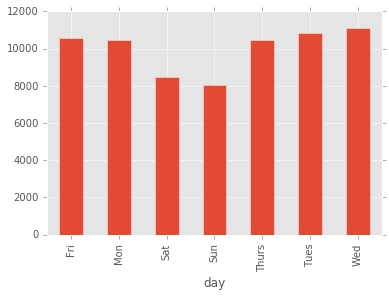

In [6]:
# Plot the number of email campaigns per day of week
days = email_data.groupby('day')['day'].count()
days.plot(kind="bar")
# Looks like less campaigns on the weekends, makes sense

In [7]:
# Explore quantitative data
email_quant = email_data.drop(['id','from_domain_hash','day','Domain_extension'],axis=1)

/home/mysterion/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


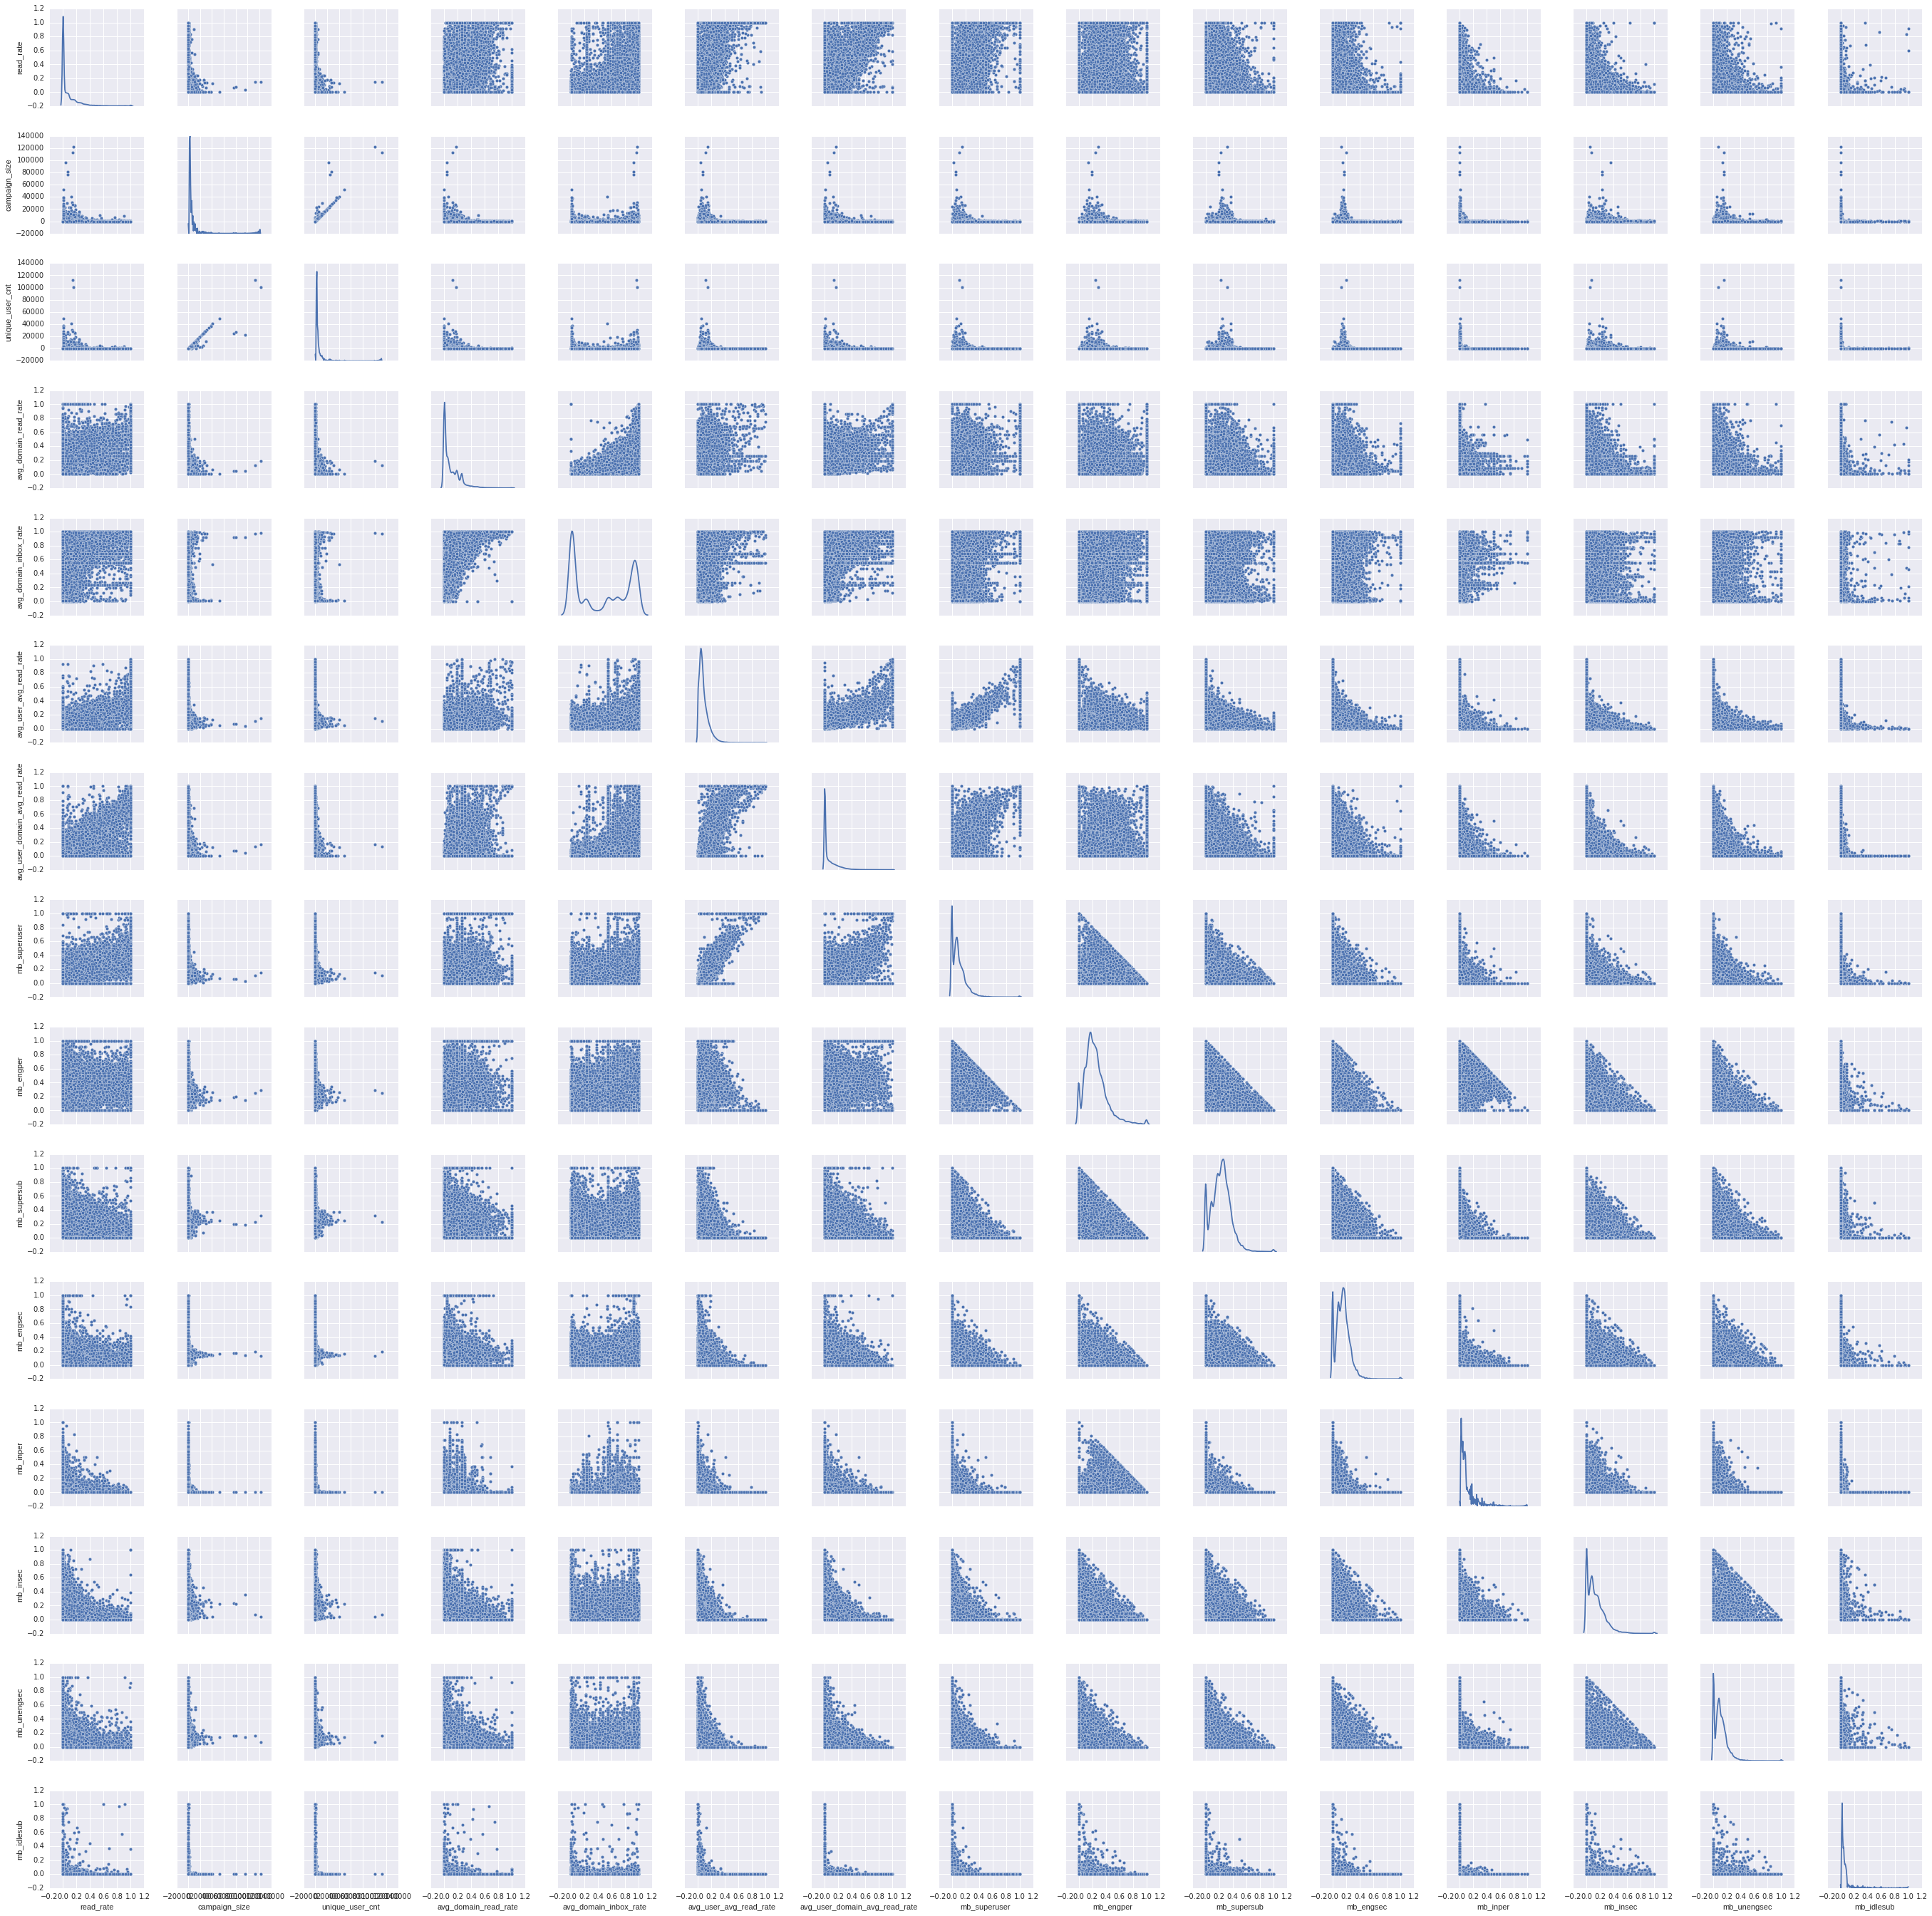

In [8]:
import seaborn as sns
sns.set()
sns.pairplot(email_quant,diag_kind='kde')

In [ ]:
Note: Interpret this scatter matrix

# Loading and splitting the data for cross-validation
Split the data into training and test sets.

In [9]:
# Hold out 20% of the data for testing and leave 80% for training
from sklearn.cross_validation import train_test_split
ed_train, ed_test = train_test_split(email_data, test_size=0.2)
print("Train size: ", ed_train.shape, "Test size: ", ed_test.shape)

Train size:  (56000, 19) Test size:  (14000, 19)


# Create and evaluate a baseline model and log loss evaluation
Using the average label in the training set as the constant prediction value independent of the features is a very simple baseline model. A baseline provides a useful benchmark to compare the evaluation of machine learning models.

In [14]:
avg_read_rate_train = ed_train['read_rate'].mean()
print(avg_read_rate_train)

0.09485928049248217


## Log loss

Log loss is a standard evaluation criterion when predicting rare-events like read rates. I am borrowing this evaluation metric from a Kaggle competition that predicted click-through rates ([Criteo Kaggle competition](https://www.kaggle.com/c/criteo-display-ad-challenge)).

Log loss is defined as:

\\[ \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \\] where \\( \scriptsize p\\) is a probability between 0 and 1 and \\( \scriptsize y\\) is a label of either 0 or 1.

In [ ]:
epsilon = 1e-16

def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.
    
    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
    """
    df = df

In [19]:
epsilon = 1e-16
ed_train[ed_train['read_rate']==1.0,ed_train['read_rate']-epsilon).otherwise(ed_train['read_rate']))

NameError: name 'when' is not defined

# Data modeling

The goal is to use machine learning to determine a function that yields the read rate of a campaign as a function of a set of predictor features.

The first model will be based on a logistic regression of the quantitative variables, since it models the probability of a read event rather than returning a binary response, and when working with rare events, probablisitc predictions are useful.

# One-hot-encoding

Would like to convert categorical features (from_domain_hash, Domain_extension, day) to numerical features.
A one-hot-encoding scheme represents each category as a binary feature.